In [1]:
# Do some imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt



# Load data and process data
data_dir = "../data/"

In [2]:
def load_data(data_dir):
    train = pd.read_json(data_dir+"train.json")
    test = pd.read_json(data_dir+"test.json")
    # Fill 'na' angles with zero
    train.inc_angle = train.inc_angle.replace('na', 0)
    train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
    test.inc_angle = test.inc_angle.replace('na', 0)
    test.inc_angle = test.inc_angle.astype(float).fillna(0.0)
    return train, test

train, test = load_data(data_dir)

In [3]:
# Process data into images
def process_images(df):
    X_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1"]])
    X_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2"]])
    # Merge bands and add another band as the mean of Band 1 and Band 2 (useful for the ImageDataGenerator later)
    imgs = np.concatenate([X_band1[:, :, :, np.newaxis]
                            , X_band2[:, :, :, np.newaxis]
                            ,((X_band1+X_band2)/2)[:, :, :, np.newaxis]], axis=-1)
    return imgs

X_train = process_images(train)
X_test = process_images(test)

X_angle_train = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
y_train = np.array(train["is_iceberg"])

In [4]:
np.max(X_train[:,:,:,:])

34.574917

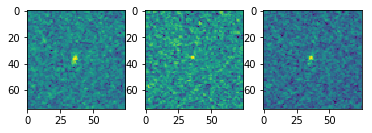

1


In [5]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(X_train[2,:,:,0])
ax[1].imshow(X_train[2,:,:,1])
ax[2].imshow(X_train[2,:,:,2])
plt.show()
print(y_train[2])

The MatLab code for doing the EMD can be run from python by starting a MatLab-engine instance

In [6]:
import matlab.engine

In [7]:
epsilon = 0.1
numberimfs = 6
conn = '8m'
eng = matlab.engine.start_matlab()

In [37]:
# Calculate IMFs, residue, and medel(?) using matlab wrapper
def IEMD(img, epsilon=0.1, numberimfs=6, conn='8m'):
    matlab_arr = matlab.double(img.tolist())
    matlab_imfs, matlab_residue, matlab_medel = eng.IEMD_public(matlab_arr, epsilon, numberimfs, conn, nargout=3) 
    
    imfs = np.asarray(matlab_imfs)
    residue = np.asarray(matlab_residue)
    medel = np.asarray(matlab_medel)
    return imfs, residue, medel

In [65]:
def plot_IEMD(img, imfs):
    fig, ax = plt.subplots(3,1 + np.shape(imfs)[2], figsize=(20, 12))
    fig.tight_layout(h_pad=3)
    fig.subplots_adjust(hspace=0.1)

    ax[0][0].imshow(img)
    ax[0][0].set_title("Original image")
    ax[1][0].imshow(img)
    ax[1][0].set_title("Original image")
    ax[2][0].imshow(img)
    ax[2][0].set_title("Original image")

    filtered_img_sub = np.copy(img)
    filtered_img_add = np.copy(img)
    for imf in range(np.shape(imfs)[2]):
        ax[0][imf + 1].imshow(imfs[:,:,imf])
        ax[0][imf + 1].set_title("IMF" + str(imf + 1))

        filtered_img_sub = filtered_img_sub - imfs[:,:,imf]
        ax[1][imf + 1].imshow(filtered_img_sub)
        ax[1][imf + 1].set_title(str(imf + 1) + " IMF(s) subtracted")

        filtered_img_add = filtered_img_add + imfs[:,:,imf]
        ax[2][imf + 1].imshow(filtered_img_add)
        ax[2][imf + 1].set_title(str(imf + 1) + " IMF(s) added")


    plt.show()
    print(y_train[2])

In [70]:
img = X_train[1,:,:,0]
imfs, residue, medel = IEMD(img)


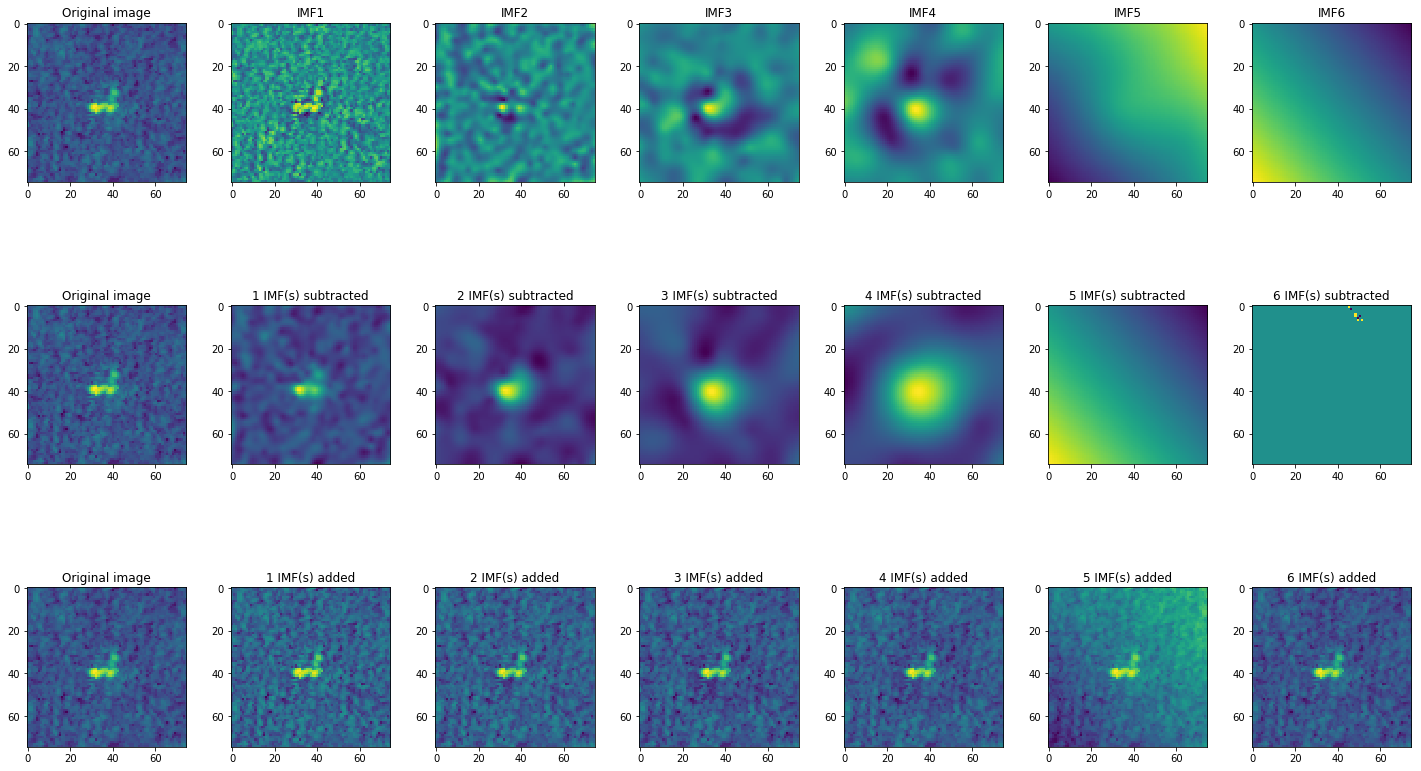

1


In [71]:
plot_IEMD(img, imfs)